In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/geoffreydsmith/Rent-prediction/main/House_Rent_Dataset.csv")
df.info()
for col in df.columns:
    print(col, " has ", sum(df[col].isna()), " NA values.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB
Posted On  has  0  NA values.
BHK  has  0  NA values.
Rent  has  0  NA values.
Size  has  0  NA values.
Floor  has  0  NA values.
Area Type  has  0  NA values.
Area Locality  has  0  

In [3]:
df.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [4]:
df.Rent.describe()

count    4.746000e+03
mean     3.499345e+04
std      7.810641e+04
min      1.200000e+03
25%      1.000000e+04
50%      1.600000e+04
75%      3.300000e+04
max      3.500000e+06
Name: Rent, dtype: float64

There are twelve features, 7 fundamentally categorical, 4 (Posted On, BHK, Size, Bathroom) numerical, and the one planned label, Rent. Based on this setup, I suspect random forests will provide a lot of good info. Let's first find out how many categories the categorical features represent.

In [5]:
categorical_features = ["Floor", "Area Type", "Area Locality", 
                        "City", "Furnishing Status", "Tenant Preferred", "Point of Contact"]
numerical_features = ["Posted On", "BHK", "Size", "Bathroom"]
label = ["Rent"]

In [6]:
for feature in categorical_features:
    print(feature, " takes ", len(df[feature].unique()), "unique values.")

Floor  takes  480 unique values.
Area Type  takes  3 unique values.
Area Locality  takes  2235 unique values.
City  takes  6 unique values.
Furnishing Status  takes  3 unique values.
Tenant Preferred  takes  3 unique values.
Point of Contact  takes  3 unique values.


There are way too many Area Locality features to include without very careful regularization.
In future work, it may make sense to create numerical variables latitude and longitude out of the Area Locality, but I will simply drop it in this version. Floor is more subtle, and we can do a little feature engineering with it.

In [7]:
df["Floor"].unique()

array(['Ground out of 2', '1 out of 3', '1 out of 2', 'Ground out of 1',
       'Ground out of 4', '1 out of 4', '1 out of 1', 'Ground out of 3',
       '2 out of 3', '4 out of 5', '2 out of 2', '2 out of 5',
       '4 out of 14', '3 out of 3', '5 out of 5', '4 out of 4',
       '7 out of 8', '2 out of 4', '3 out of 4', '1 out of 5',
       '8 out of 5', 'Ground out of 6', '2 out of 1',
       'Upper Basement out of 4', 'Ground out of 5', '3 out of 5',
       '11 out of 19', '5 out of 10', '11 out of 14',
       'Lower Basement out of 2', '2 out of 7', '4 out of 10',
       '7 out of 10', '2 out of 13', '6 out of 7', '4 out of 7',
       '14 out of 14', '43 out of 78', '2 out of 8', '13 out of 18',
       '5 out of 12', '18 out of 24', '3 out of 7', '17 out of 31',
       '11 out of 21', '7 out of 19', '14 out of 23', '9 out of 20',
       'Upper Basement out of 9', '19 out of 24', '3 out of 21',
       '1 out of 22', '8 out of 8', '6 out of 12', '4 out of 58',
       'Upper Basement o

For Floor it seems plausible that it's worthwhile to identify basement, ground, and otherwise apartments. So let's make new features.

In [8]:
df=df.assign(Basement =  df.Floor.str.contains("Basement"))
df=df.assign(Ground = df.Floor.str.contains("Ground"))
def b_or_g(row):
    for c in ["Basement", "Ground"]:
        if row[c]:
            return c
    return None
df = df.assign(BG = df.apply(b_or_g, axis=1))
df.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Basement,Ground,BG
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,False,True,Ground
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,False,False,None
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,False,False,None
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,False,False,None
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner,False,False,None


In [9]:
print(df.Basement.value_counts())
print(df.Ground.value_counts())

False    4712
True       34
Name: Basement, dtype: int64
False    3819
True      927
Name: Ground, dtype: int64


Text(0.5, 1.0, 'Rent vs ground or basement status')

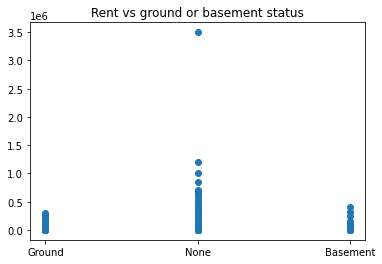

In [10]:
plt.scatter(x=df.BG.astype(str), y=df.Rent)
plt.title("Rent vs ground or basement status")

 Nothing super fancy underground or on the ground floor! . That said, there is a big outlier, so let's take a look at that

In [11]:
df.sort_values(ascending = False, by=['Rent']).head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Basement,Ground,BG
1837,2022-06-08,3,3500000,2500,4 out of 4,Carpet Area,Marathahalli,Bangalore,Semi-Furnished,Bachelors,3,Contact Agent,False,False,None
1001,2022-06-01,4,1200000,5000,4 out of 15,Carpet Area,Juhu,Mumbai,Semi-Furnished,Bachelors/Family,4,Contact Agent,False,False,None
827,2022-05-18,4,1000000,3064,18 out of 45,Carpet Area,"Raheja Artesia, Worli",Mumbai,Semi-Furnished,Family,4,Contact Agent,False,False,None
1329,2022-06-23,4,850000,3200,2 out of 4,Carpet Area,Breach Candy,Mumbai,Furnished,Bachelors/Family,4,Contact Agent,False,False,None
1459,2022-06-27,4,700000,3200,24 out of 24,Carpet Area,"Lady Ratan Tower, Worli",Mumbai,Furnished,Bachelors/Family,4,Contact Agent,False,False,None


That is one big outlier rent-wise. Luckily, with random forests, it would take some serious overfitting for that to matter, though it may cause some artificially high errors we'll have to take into account. Let's now see how predictive these features are.

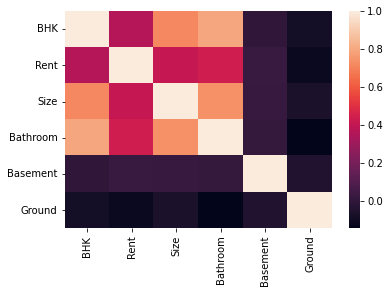

In [12]:
corr = df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

The Basement and Ground features do nont particularly correlate with the other features, I suspect mostly because there are so few of them. Unsurprisingly, Size is very important. Next, let's handle dates.

In [13]:
sorted(df['Posted On'].unique())

['2022-04-13',
 '2022-04-23',
 '2022-04-24',
 '2022-04-25',
 '2022-04-26',
 '2022-04-27',
 '2022-04-28',
 '2022-04-29',
 '2022-04-30',
 '2022-05-01',
 '2022-05-02',
 '2022-05-03',
 '2022-05-04',
 '2022-05-05',
 '2022-05-06',
 '2022-05-07',
 '2022-05-08',
 '2022-05-09',
 '2022-05-10',
 '2022-05-11',
 '2022-05-12',
 '2022-05-13',
 '2022-05-14',
 '2022-05-15',
 '2022-05-16',
 '2022-05-17',
 '2022-05-18',
 '2022-05-19',
 '2022-05-20',
 '2022-05-21',
 '2022-05-22',
 '2022-05-23',
 '2022-05-24',
 '2022-05-25',
 '2022-05-26',
 '2022-05-27',
 '2022-05-28',
 '2022-05-29',
 '2022-05-30',
 '2022-05-31',
 '2022-06-01',
 '2022-06-02',
 '2022-06-03',
 '2022-06-04',
 '2022-06-05',
 '2022-06-06',
 '2022-06-07',
 '2022-06-08',
 '2022-06-09',
 '2022-06-10',
 '2022-06-11',
 '2022-06-12',
 '2022-06-13',
 '2022-06-14',
 '2022-06-15',
 '2022-06-16',
 '2022-06-17',
 '2022-06-18',
 '2022-06-19',
 '2022-06-20',
 '2022-06-21',
 '2022-06-22',
 '2022-06-23',
 '2022-06-24',
 '2022-06-25',
 '2022-06-26',
 '2022-06-

The days here  represent a three month period. This is clearly numerical data, and can likely be cleaned and made relevant. Pandas can handle this. 

In [14]:
def count_days(startDate, endDate):
    return (pd.to_datetime(endDate, format = "%Y-%m-%d") - 
            pd.to_datetime(startDate, format = "%Y-%m-%d")).dt.days
df = df.assign(Day = lambda x: count_days("2022-04-13", x["Posted On"]))

In [15]:
df.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Basement,Ground,BG,Day
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,False,True,Ground,35
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,False,False,None,30
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,False,False,None,33
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,False,False,None,82
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner,False,False,None,26


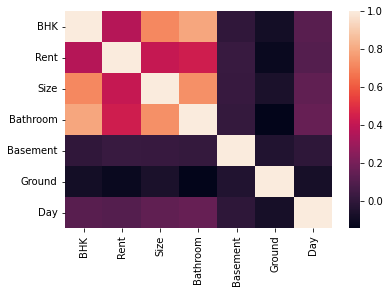

In [16]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

What interesting correlations! Ok, at this point we've added all the features I think we plausibly would need. Let's implement some models.

In [17]:
relevant_cols = ["Day", "BHK", "Size", "Bathroom", "Basement", "Ground", "Area Type","City", "Furnishing Status", "Tenant Preferred", "Point of Contact"]
X = df[relevant_cols]
y= df["Rent"]

In [18]:
X.head()

,Day,BHK,Size,Bathroom,Basement,Ground,Area Type,City,Furnishing Status,Tenant Preferred,Point of Contact
0,35,2,1100,2,False,True,Super Area,Kolkata,Unfurnished,Bachelors/Family,Contact Owner
1,30,2,800,1,False,False,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,Contact Owner
2,33,2,1000,1,False,False,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,Contact Owner
3,82,2,800,1,False,False,Super Area,Kolkata,Unfurnished,Bachelors/Family,Contact Owner
4,26,2,850,1,False,False,Carpet Area,Kolkata,Unfurnished,Bachelors,Contact Owner


We have to do one-hot encoding on the remaining categorical features. So let's do that!

In [19]:
cats = ['Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact', 'Basement', 'Ground']
for cat in cats:
    X = X.join(pd.get_dummies(X[cat], prefix=cat))
    X = X.drop(cat, axis=1)
    

In [20]:
X.head()

,Day,BHK,Size,Bathroom,Area Type_Built Area,Area Type_Carpet Area,Area Type_Super Area,City_Bangalore,City_Chennai,City_Delhi,...,Tenant Preferred_Bachelors,Tenant Preferred_Bachelors/Family,Tenant Preferred_Family,Point of Contact_Contact Agent,Point of Contact_Contact Builder,Point of Contact_Contact Owner,Basement_False,Basement_True,Ground_False,Ground_True
0,35,2,1100,2,0,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,1
1,30,2,800,1,0,0,1,0,0,0,...,0,1,0,0,0,1,1,0,1,0
2,33,2,1000,1,0,0,1,0,0,0,...,0,1,0,0,0,1,1,0,1,0
3,82,2,800,1,0,0,1,0,0,0,...,0,1,0,0,0,1,1,0,1,0
4,26,2,850,1,0,1,0,0,0,0,...,1,0,0,0,0,1,1,0,1,0


In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4) 


In [22]:
from sklearn.ensemble import RandomForestRegressor
#to start,  picking sensible-sounding hyperparameters, we'll test validity on oob examples
rfr = RandomForestRegressor(n_estimators = 250, max_depth = 4, oob_score = True)

In [23]:
rfr.fit(X_train,y_train)

RandomForestRegressor(max_depth=4, n_estimators=250, oob_score=True)

In [24]:
rfr.oob_score_

0.7069125568894157

The first  oob score this popped out was .6921, and further implementations with n_estimators = 250 and max_leaf_nodes = 32 produce similar numbers. Using max_depth=4 instead improved things slightly to .71 or so. Not great!

In [25]:
from sklearn.metrics import mean_squared_error as mse
print("Training error: ",np.sqrt(mse(y_train, rfr.predict(X_train))))
print("Test error: ", np.sqrt(mse(y_test, rfr.predict(X_test))))

Training error:  26459.067294297427
Test error:  116126.61363776824


The truly vast difference between the training and test errors suggest that one is distorted by the presence of outliers, especially the 3.5 million rent we saw before. This doesn't necessarily call for retraining the model, but verifying the hypothesis that the difference is due to the very large outliers. Rather than messing with the data, I'm going to introduce a new error function that caps the contribution to the error any single data point can provide.

In [26]:
def mse_capped(ar1, ar2, cap):
    n = len(ar1)
    sum = 0
    for i in range(n):
        sum += min((ar1[i] - ar2[i]) ** 2, cap ** 2)
    return sum/n
print("Capped training error", 
      np.sqrt(mse_capped(y_train.to_numpy(), rfr.predict(X_train), 300000)))
print("Capped test error", 
      np.sqrt(mse_capped(y_test.to_numpy(), rfr.predict(X_test), 300000)))


Capped training error 25615.184148883473
Capped test error 28985.44721725813


We can compare this to guessing the average:

In [27]:
n = len(X_test)
print("Trivial estimator", 
      np.sqrt(mse_capped(np.full(n, df.Rent.mean()), rfr.predict(X_test), 300000)))


Trivial estimator 44284.91591358186


So the random forest model reflects some predictive value. But how do other models stack up? Note that because we no longer have OOB scores for hyperparameter tuning, we handle parameter tuning with cross-validation instead.

In [28]:
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
models = {
    "lm": linear_model.LinearRegression(),
    "ridge": linear_model.Ridge(alpha=0.5),
    "lasso": linear_model.Lasso(alpha=0.2, tol=.1),
    "rfr": RandomForestRegressor(n_estimators=250, max_depth=4, oob_score=True, 
                                 random_state=4),
    "gbr": GradientBoostingRegressor(n_estimators=250, learning_rate=0.2, max_depth=4, 
                                     random_state=4)
}

Train and provide validation scores for each model, for hyperparameter tuning.

In [29]:
for key in models:
    print(key, cross_val_score(models[key], X_train, y_train, cv=5))


lm [0.50621846 0.53406944 0.58179241 0.49303807 0.51342182]
ridge [0.50631042 0.53406214 0.58212182 0.49301125 0.51345279]
lasso [0.506239   0.53406976 0.58182404 0.49297331 0.51342159]
rfr [0.71244185 0.75869027 0.66728595 0.71486522 0.66578442]
gbr [0.67347196 0.74086443 0.66685728 0.73058516 0.61557237]


None obviously beat random forests either before or after tuning, but let's see how well they do.

As an additional note, I remark that lasso had trouble converging; hence the high tolerance. I suspect that we run into some colinearity issues with the one-hot encoding of the Basement and Ground columns.

In [30]:
for key in models:
    models[key].fit(X_train, y_train)

In [31]:
train_errors ={}
test_errors = {}
for key in models:
    train_errors[key] = np.sqrt(mse_capped(y_train.to_numpy(), 
                                           models[key].predict(X_train), 300000))
    test_errors[key] = np.sqrt(mse_capped(y_test.to_numpy(), 
                                           models[key].predict(X_test), 300000))
mean = df.Rent.mean()
train_errors["trivial"] = np.sqrt(mse_capped(np.full(len(y_train), mean), 
                                             rfr.predict(X_train), 300000))
test_errors["trivial"] = np.sqrt(mse_capped(np.full(len(y_test), mean), 
                                            rfr.predict(X_test), 300000))
labels = list(train_errors.keys())
train_errors_list = list(train_errors.values())
test_errors_list = list(test_errors.values())


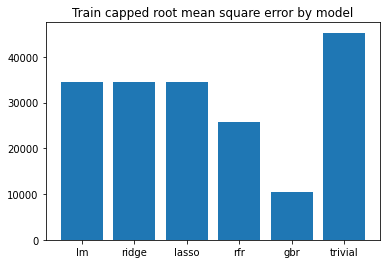

In [32]:
plt.bar(range(len(labels)), train_errors_list, tick_label=labels)
plt.title("Train capped root mean square error by model")
plt.show()

Gradient boosting has suspiciously low train error. Is it overfitting?

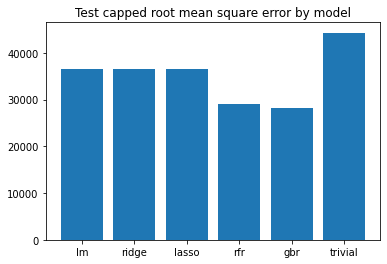

In [33]:
plt.bar(range(len(labels)), test_errors_list, tick_label=labels)
plt.title("Test capped root mean square error by model")
plt.show()

In [34]:
test_errors["gbr"]

28286.070269192707

It is, but still manages to be today's winner with a capped MSE of 28,286. That said, every model adds some information. To end, let's just see which features the linear model takes seriously.

In [35]:
dict(zip(X_train.columns, models["lm"].coef_))

{'Day': -57.4123763918039,
 'BHK': 735.381385802095,
 'Size': 39.91089852424392,
 'Bathroom': 12419.98154018575,
 'Area Type_Built Area': 5294.714307054602,
 'Area Type_Carpet Area': -1143.2757008865317,
 'Area Type_Super Area': -4151.438606196384,
 'City_Bangalore': -9230.68539238673,
 'City_Chennai': -12658.31894802212,
 'City_Delhi': 3894.6841271315416,
 'City_Hyderabad': -21200.52481037222,
 'City_Kolkata': -7203.687156807359,
 'City_Mumbai': 46398.532180454284,
 'Furnishing Status_Furnished': 4739.910544415582,
 'Furnishing Status_Semi-Furnished': -2670.316503073571,
 'Furnishing Status_Unfurnished': -2069.5940413294247,
 'Tenant Preferred_Bachelors': -463.5987934090635,
 'Tenant Preferred_Bachelors/Family': 5073.149398243736,
 'Tenant Preferred_Family': -4609.550604830038,
 'Point of Contact_Contact Agent': -5607.125846468857,
 'Point of Contact_Contact Builder': 19109.108776945854,
 'Point of Contact_Contact Owner': -13501.982930439837,
 'Basement_False': -1593.1466507310538,
 '

Based on this list, we see that Size, Bathroom, City_Hyderabad, and City_Mumbai are probably the most significant features, and the date posted is relevant, while, to my surprise, there is barely any discernable impact from being a basement apartment.

But the final upshot is that, though the ensemble models beat the linear models beat the trivial model, a lot of the variation in Rent is not clearly handled by the data we used here. In updated versions of this notebook, I would want to add the location data from Area Locality (recall that it was dropped in this version), and use latitude/longitude to inform the regression.